# MRS Band 2A ref point fit
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven), with updates from Alvaro Labiano (CAB)  
Creation date 9th October 2018

### > Import modules

In [7]:
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from scipy import signal
from datetime import date
from astropy.io import fits
import scipy.interpolate as scp_interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

### > Set directories

In [2]:
# USER:
user = "yannis" # "yannis"

# Set work directory
# *** Change these to more general folders like"./data_for_notebook_test/" that we can all have
if user == "alvaro":
    workDir = "./"
    
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/"

### > Give analysis inputs

In [3]:
# inputs
band = '2A'                     # spectral band under investigation
lamblower,lambupper = 7.47,8.83   # nominal wavelength range of band 1C
islice    = 10                  # slice number (equivalent to beta position)
alpha_pos = 0.                  # along-slice position, [arcsec]

## Start analysis

A reference wavelength/pixel pair is determined using the dichroic transmissions. By comparing the transmission of the dichroics determined from the lab and with the MRS, a reference wavelength can be matched to a reference pixel on the MRS detector. Let's look at the lab and MRS dichroic transmissions.

Disclaimer: during commissioning the reference point will be obtained from the spectral lines of a celestial calibrator.

### > Import filter transmission data

<IPython.core.display.Javascript object>


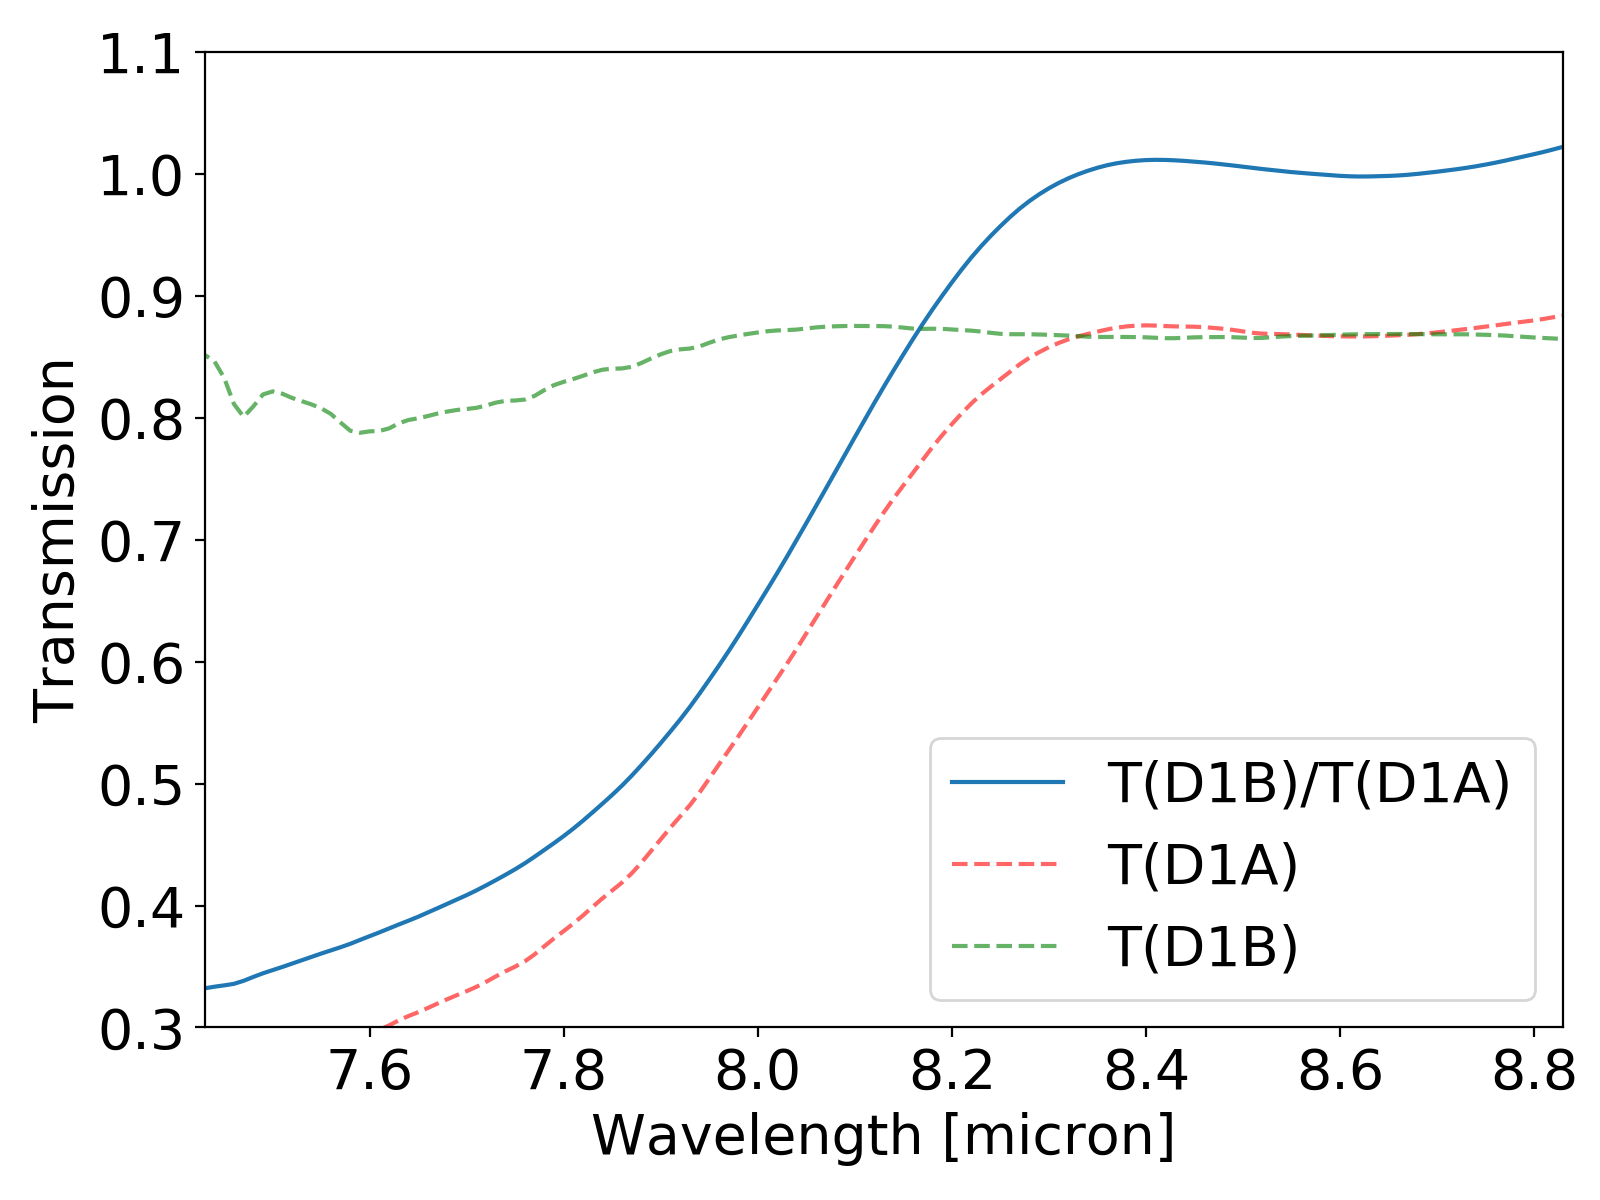

In [4]:
MRSWaveCalDir = "/Users/ioannisa/Desktop/python/miri_devel/MRSWaveCal/"
dichroicDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

# Read the measured transmission curves from the csv files
# first colum is wavelength [micrometer]
# second column is room temperature transmission
# third column is 7K transmission
col = 2
filterWave= np.genfromtxt(dichroicDir + "fm_dichroics_1a.csv", delimiter=";")[:,0]
D1A = np.genfromtxt(dichroicDir + "fm_dichroics_1a.csv", delimiter=";")[:,col]/100.
D1B = np.genfromtxt(dichroicDir + "fm_dichroics_1b.csv", delimiter=";")[:,col]/100.

# plot transmissions
plt.figure(figsize=(8,6))
plt.plot(filterWave,D1B/D1A,label='T(D1B)/T(D1A)')
plt.plot(filterWave,D1B,'r--',alpha=0.6,label='T(D1A)')
plt.plot(filterWave,D1A,'g--',alpha=0.6,label='T(D1B)')
plt.xlim(7.43,8.83)
plt.ylim(0.3,1.1)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Transmission',fontsize=20)
plt.legend(loc='lower right',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

## > Import MRS observations of filter

<IPython.core.display.Javascript object>


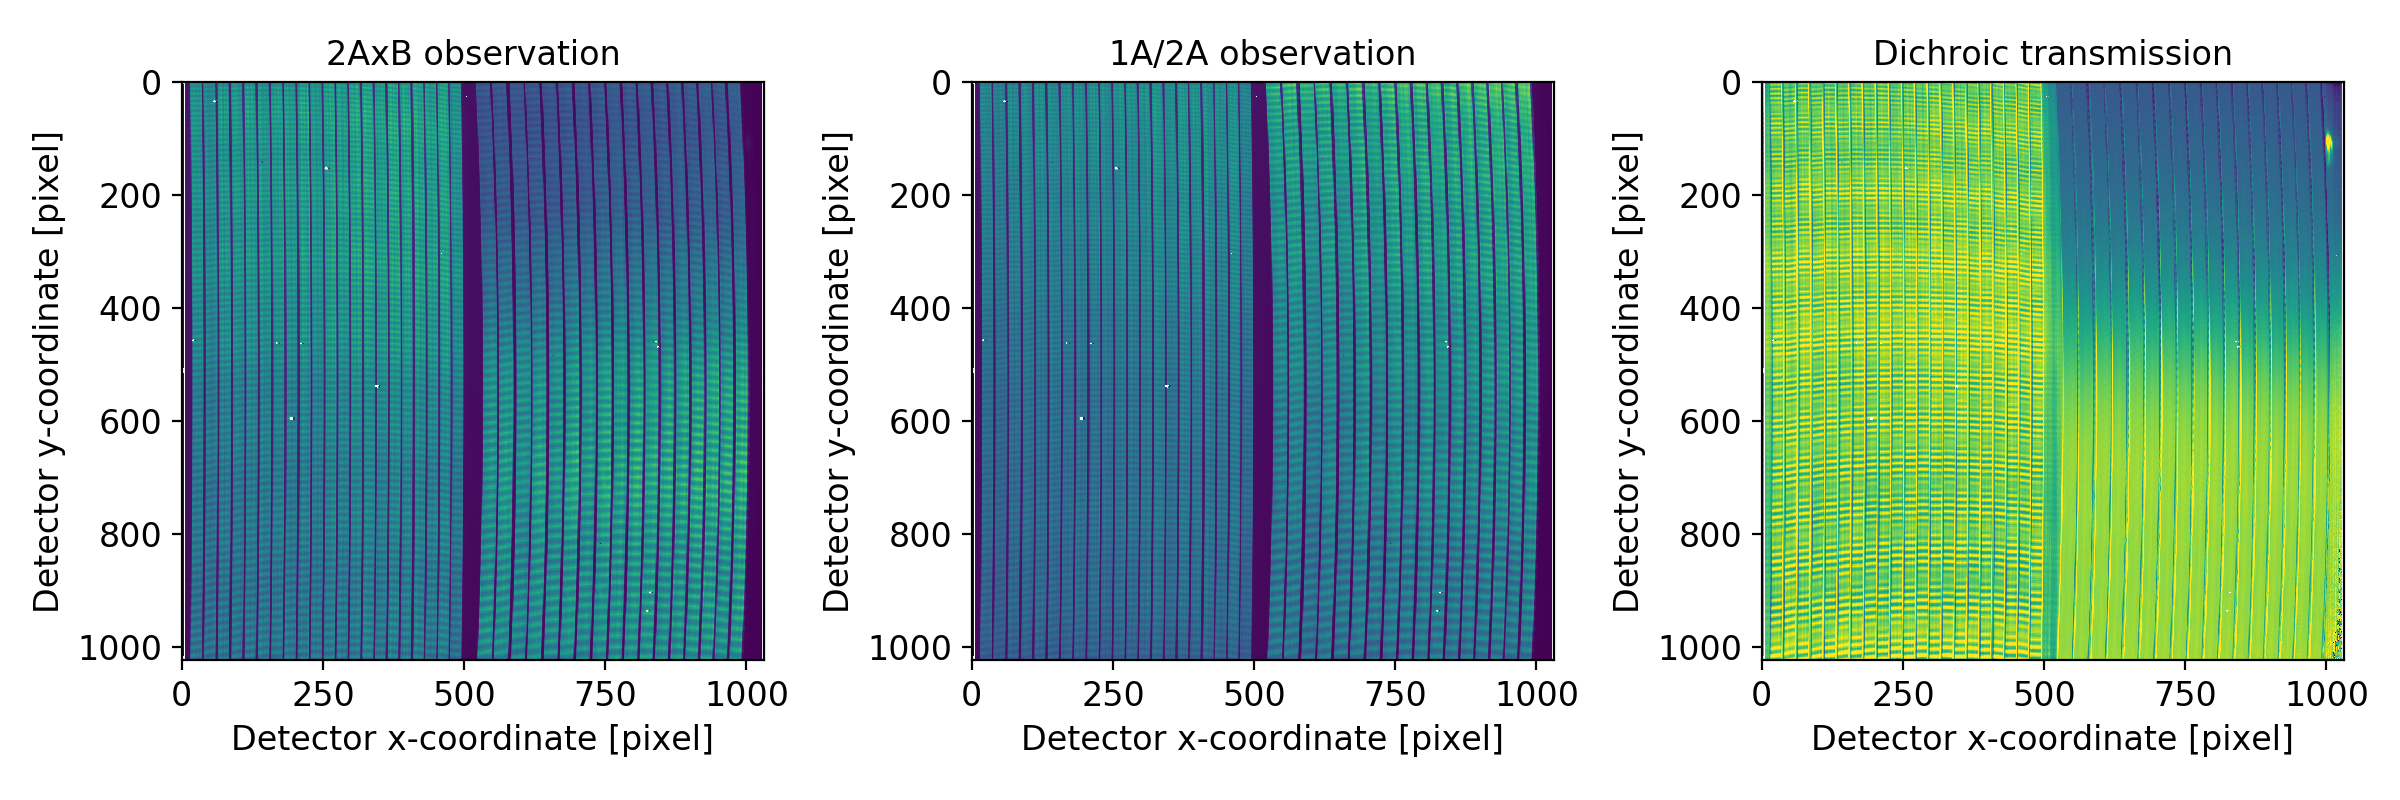

In [9]:
# top: xconfig 2AxB image, bottom: nominal 1A/2A detector image
FM1T00010413_4 = fits.open('/Users/ioannisa/Desktop/python/miri_devel/FM_data/LVL2/FM1T00010413/MIRFM1T00010413_4_495_SE_2011-05-14T15h00m07_LVL2.fits')[0].data[0,:,:]
FM1T00010413_1 = fits.open('/Users/ioannisa/Desktop/python/miri_devel/FM_data/LVL2/FM1T00010413/MIRFM1T00010413_1_495_SE_2011-05-14T14h42m39_LVL2.fits')[0].data[0,:,:]

dichroic_transmission_img = FM1T00010413_4/FM1T00010413_1

# plot
fig,axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(FM1T00010413_4)
axs[1].imshow(FM1T00010413_1)
axs[2].imshow(dichroic_transmission_img,vmin=0,vmax=1.2)
for plot in range(3):
    axs[plot].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
    axs[plot].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
    axs[plot].tick_params(axis='both',labelsize=12)
axs[0].set_title('2AxB observation',fontsize=12)
axs[1].set_title('1A/2A observation',fontsize=12)
axs[2].set_title('Dichroic transmission',fontsize=12)
plt.tight_layout()

## > Perform wavelength calibration analysis on selected position

In [10]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

<IPython.core.display.Javascript object>


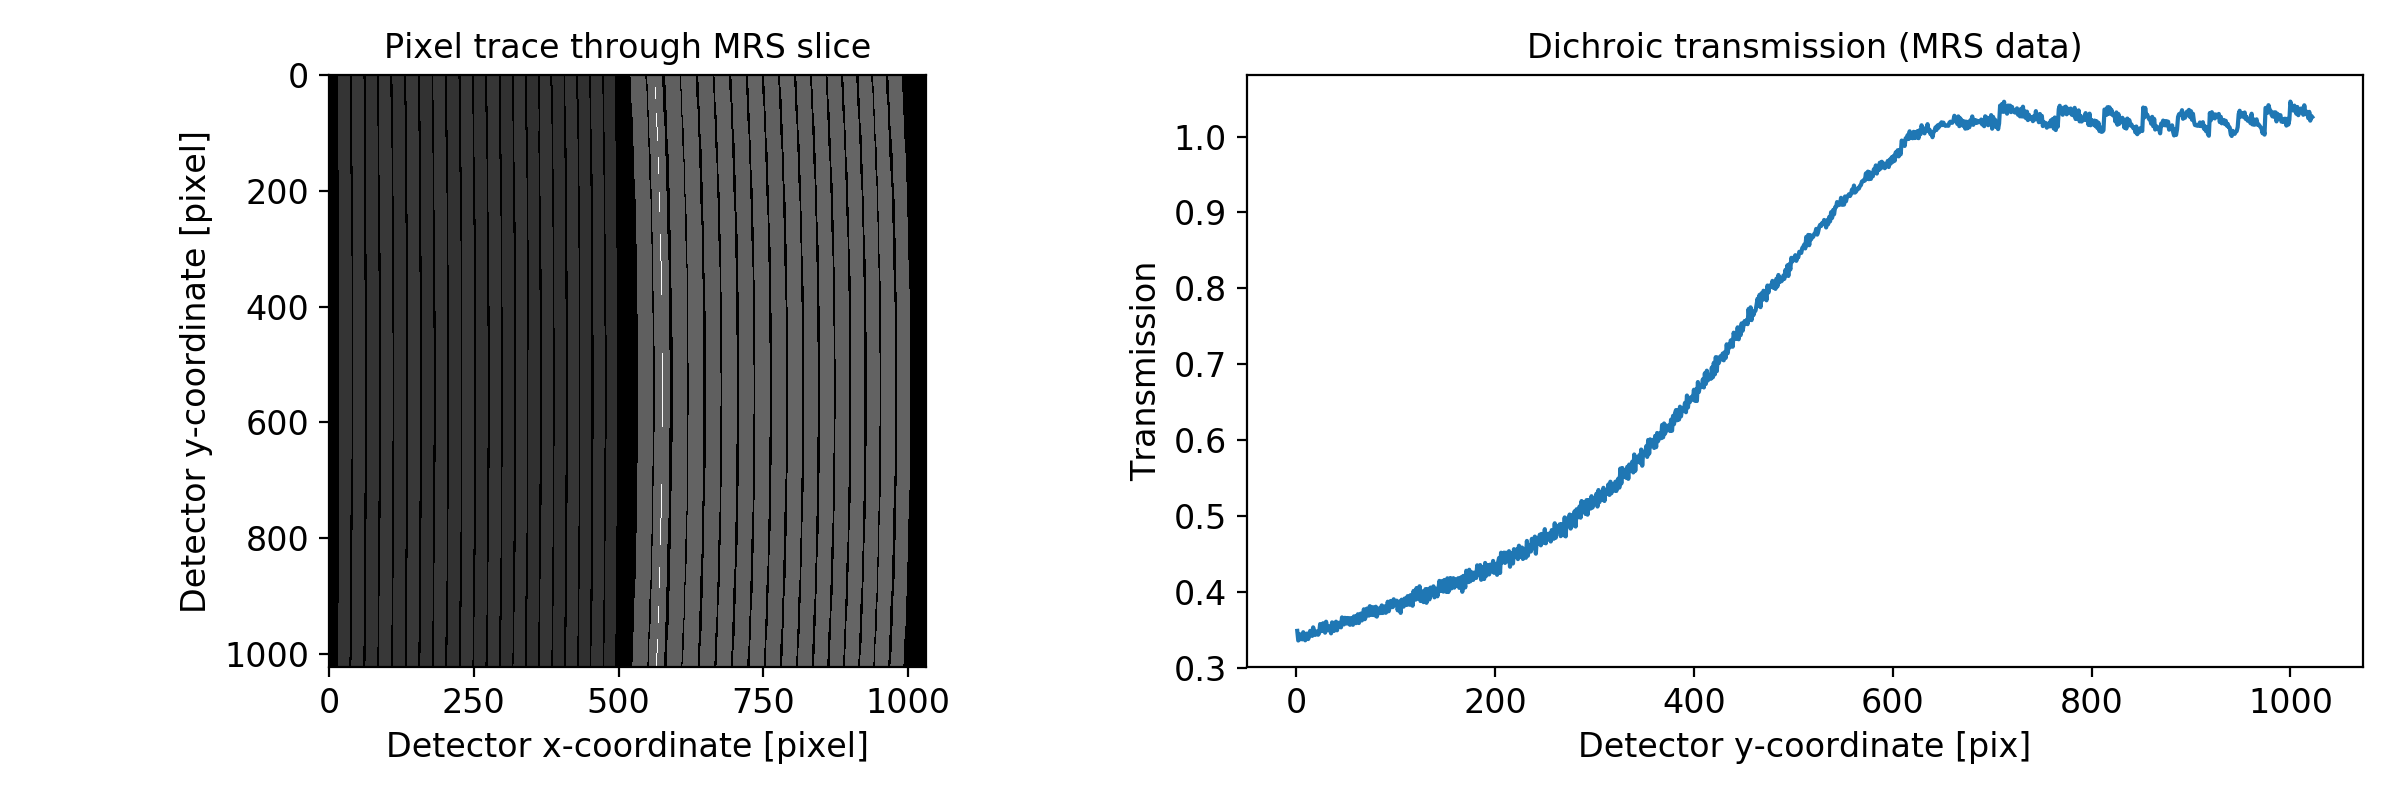

In [13]:
# take pixel trace along specified slice, specified alpha position
## ******* AL: Shall we use interpolation between closest alpha values? <-- This should result in a pixel to sub-pixel order improvement on the determination of the wavelength-pixel reference
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)

# plot trace
valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.

fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(sliceMap,cmap='gray')
axs[0].imshow(valid_img,alpha=0.6,cmap='gray')
axs[0].set_title('Pixel trace through MRS slice',fontsize=12)
axs[0].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
axs[0].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
axs[1].plot(dichroic_transmission_img[ypos,xpos])
axs[1].set_title('Dichroic transmission (MRS data)',fontsize=12)
axs[1].set_xlabel('Detector y-coordinate [pix]',fontsize=12)
axs[1].set_ylabel('Transmission',fontsize=12)
for plot in range(2): axs[plot].tick_params(axis='both',labelsize=12)
plt.tight_layout()

## > Perform wavelength calibration analysis  
Find reference wavelength in detector pixel space  
Method 1: Linear transform from wavelength to pixel coordinates  
Method 2: Relate transmission values in wavelength space and in pixel space

<IPython.core.display.Javascript object>


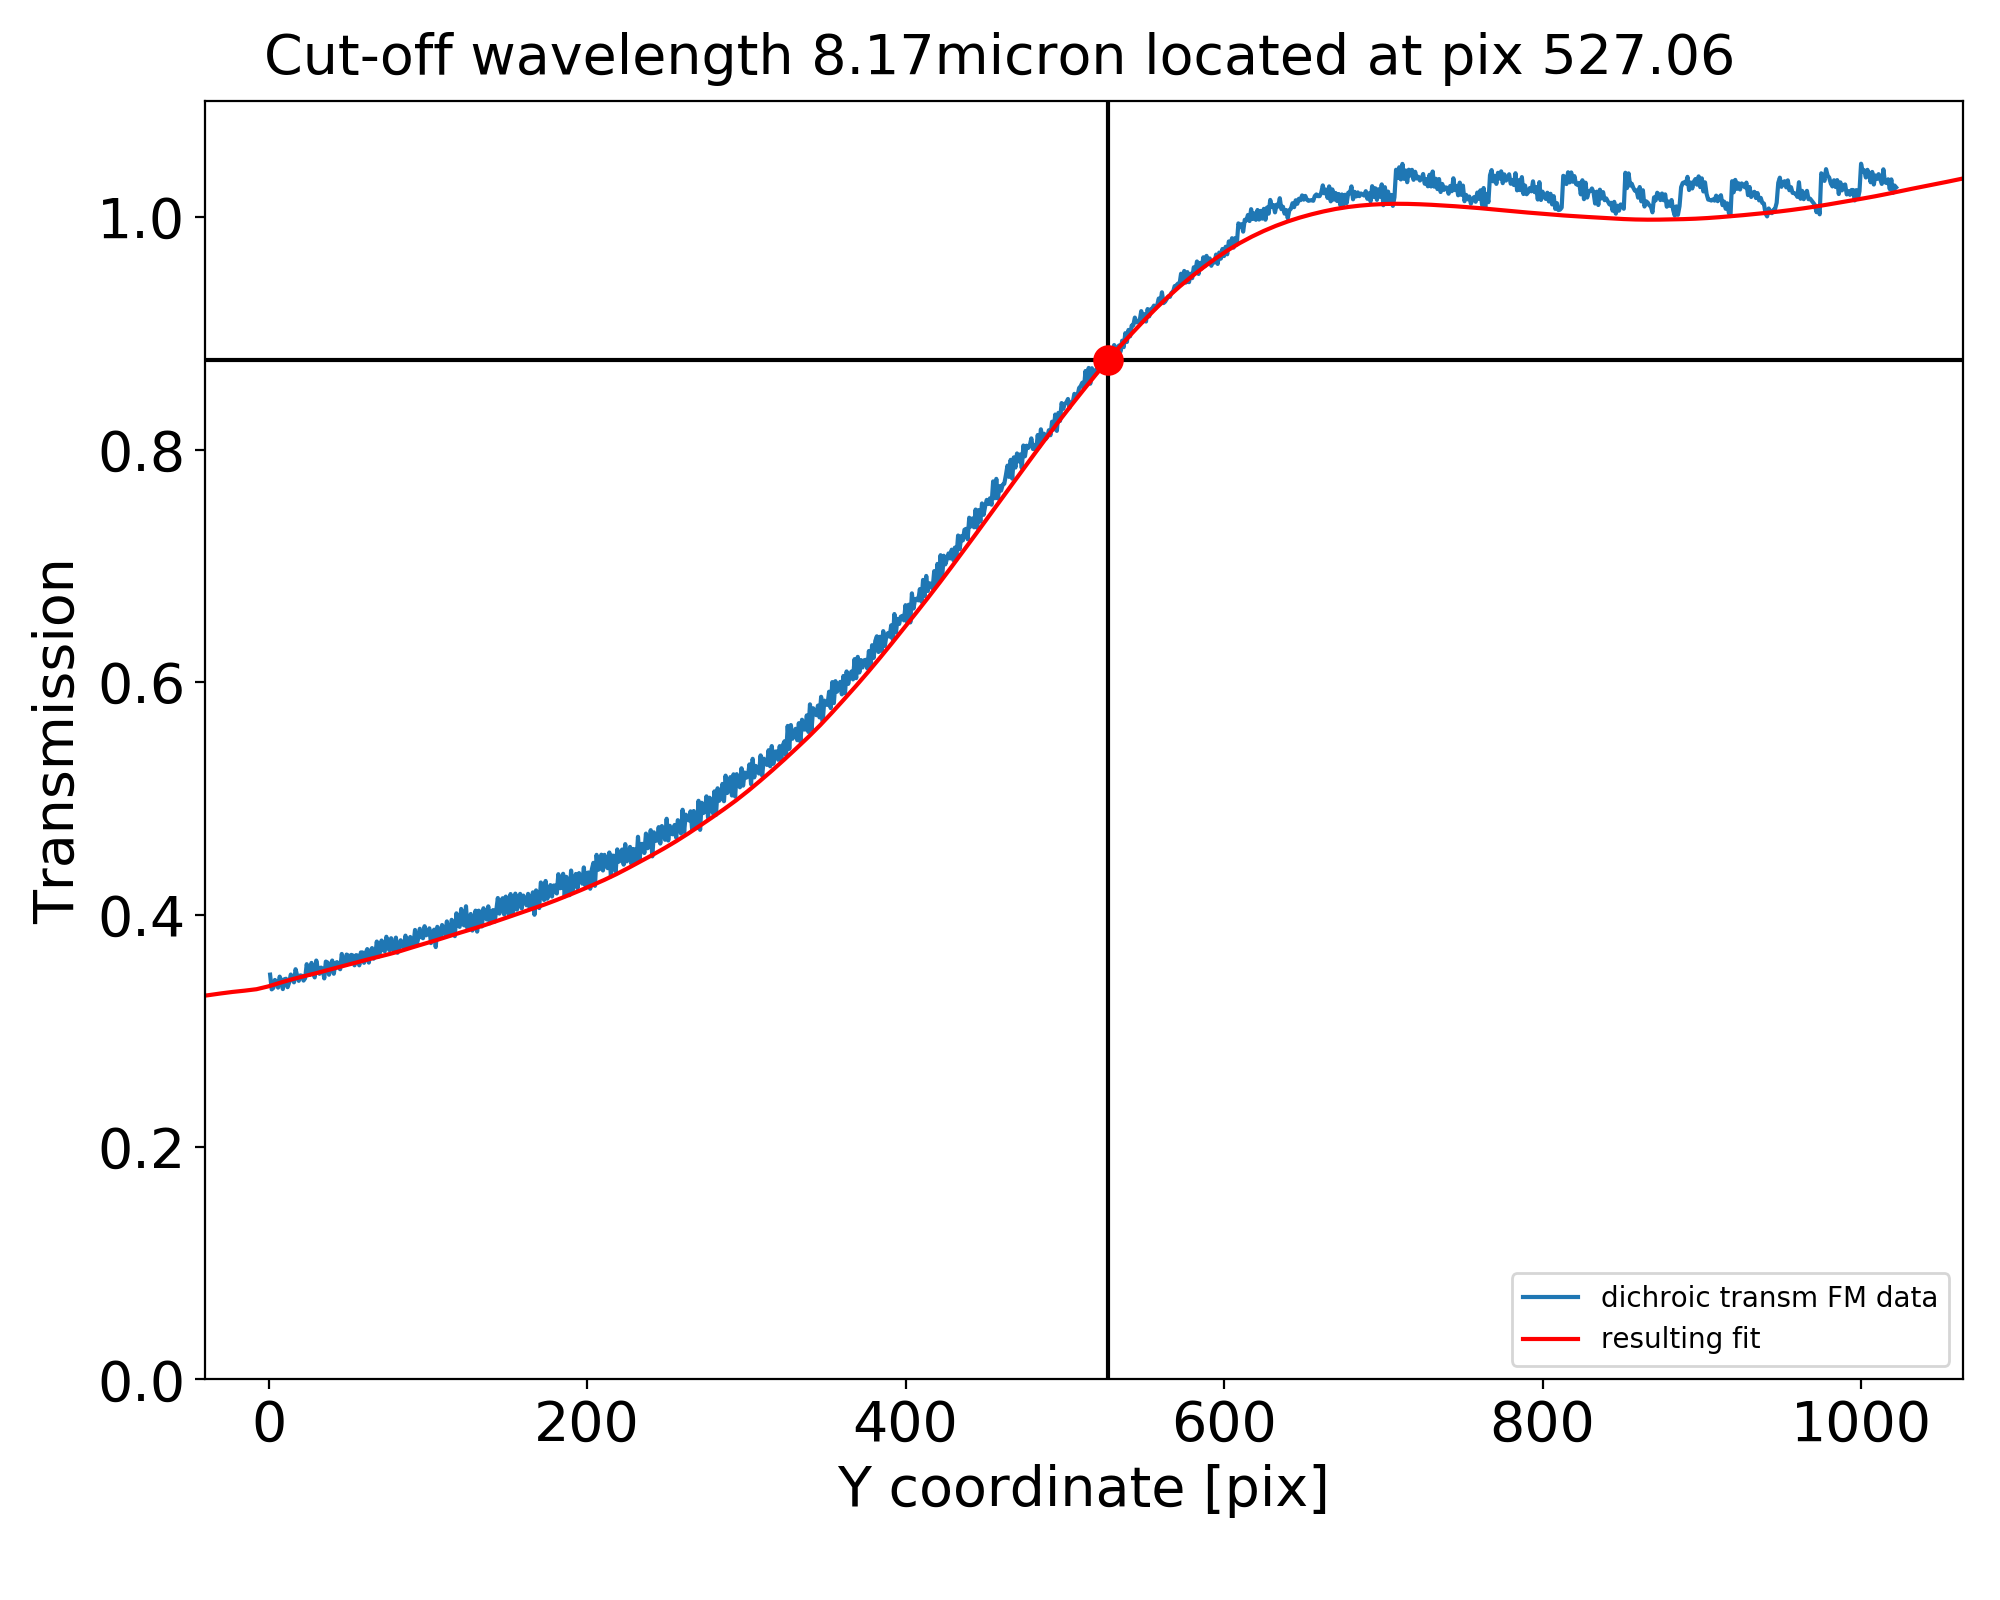

In [15]:
# Method 1 initial analysis (/ first iteration)
#--inputs
cutofflamb = 8.17
cutofflamb_idx = (np.abs(filterWave-cutofflamb)).argmin()
sci_fm_data = dichroic_transmission_img[ypos,xpos].copy()


#--apply linear transform between dichroic transmission wavelength space and detector pixel space
# (--> is a *linear* transformation between coordinates a safe assumption?)

# factor required for segments to have equal span (FM data has length=1024 (pixels))
a0 = (len(sci_fm_data)/(lambupper-lamblower))
# value required for scaled wavelength space lower limit to return to the value zero
b0 = (len(sci_fm_data)/(lambupper-lamblower))*(cutofflamb-lamblower)

# apply linear transformation
filterWaveScaled = a0*(filterWave-cutofflamb) + b0

# plot result
plt.figure(figsize=(10,8))
plt.plot(sci_fm_data,label='dichroic transm FM data')
plt.plot(filterWaveScaled,D1B/D1A,'r',label='resulting fit')
plt.plot(filterWaveScaled[cutofflamb_idx],(D1B/D1A)[cutofflamb_idx],'ro',markersize=10 )
plt.vlines(filterWaveScaled[cutofflamb_idx],0,1.1)
plt.hlines((D1B/D1A)[cutofflamb_idx],-40,1064)
plt.xlim(-40,1064)
plt.ylim(0.,1.1)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Transmission',fontsize=20)
plt.suptitle('Cut-off wavelength {}micron located at pix {}'.format(cutofflamb,round(filterWaveScaled[cutofflamb_idx],2) ),fontsize=20)
plt.legend(loc='lower right')
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])


a0,b0 scaled by a factor 0.9863,0.9855 respectively
Derived (a,b) = (742.6156,519.4088)


<IPython.core.display.Javascript object>


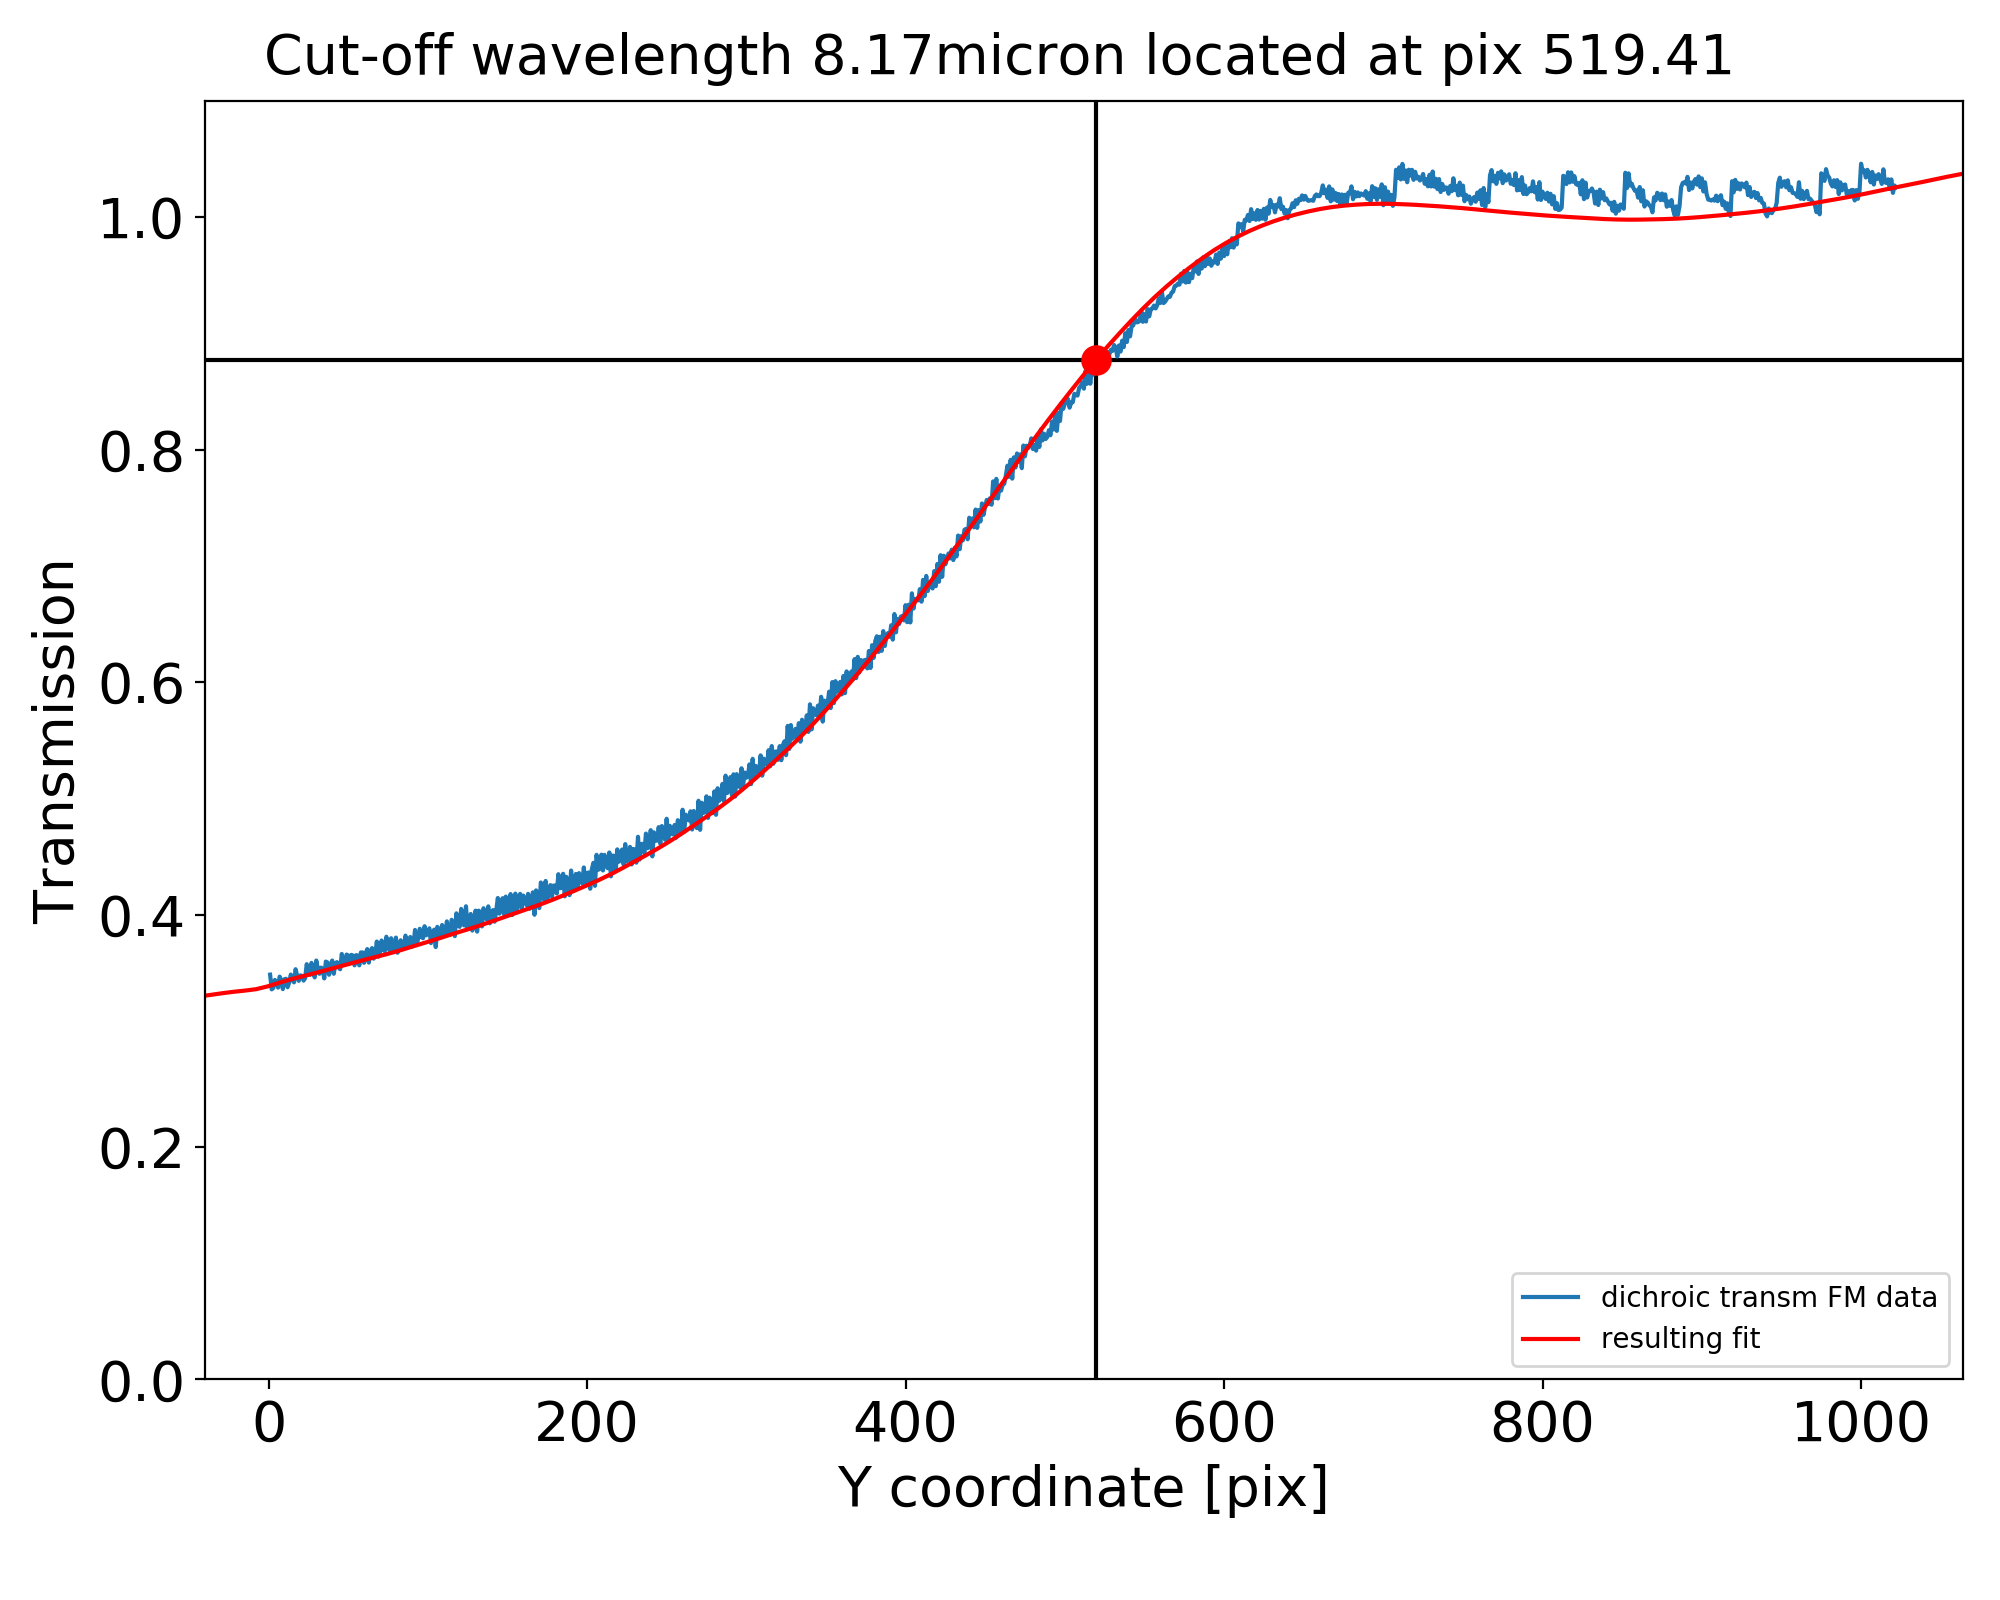

In [18]:
# Improve on the previous analysis (/ second iteration)
#--refine the proportionality factor a0
prop_factors = np.linspace(0.9,1.1,1000)
slopes = []
for prop_factor in prop_factors:
    a = prop_factor*a0
    filterWaveScaled = a*(filterWave-cutofflamb) + b0
    sel = (filterWaveScaled>=0) & (filterWaveScaled<=1024)
    dichr_transm = scp_interpolate.interp1d(filterWaveScaled[sel],(D1B/D1A)[sel])(np.linspace(filterWaveScaled[sel][0],filterWaveScaled[sel][-1],len(sci_fm_data)))
    popt = np.polyfit(np.arange(len(sci_fm_data[~np.isnan(sci_fm_data)])),sci_fm_data[~np.isnan(sci_fm_data)]/dichr_transm[~np.isnan(sci_fm_data)],1)
    slopes.append(np.abs(popt[0]))
a = prop_factors[np.array(slopes).argmin()] * a0

#--refine the added value b0
prop_factors = np.linspace(0.9,1.1,1000)
chi_squr = []
for prop_factor in prop_factors:
    b = prop_factor*b0
    filterWaveScaled = a*(filterWave-cutofflamb) + b
    sel = (filterWaveScaled>=0) & (filterWaveScaled<=1024)
    dichr_transm = scp_interpolate.interp1d(filterWaveScaled[sel],(D1B/D1A)[sel])(np.linspace(filterWaveScaled[sel][0],filterWaveScaled[sel][-1],len(sci_fm_data)))
    chi_squr.append(np.sum((sci_fm_data[~np.isnan(sci_fm_data)]-(dichr_transm[~np.isnan(sci_fm_data)]))**2))
b = prop_factors[np.array(chi_squr).argmin()] * b0

# new linear transformation
filterWaveScaled = a*(filterWave-cutofflamb) + b
print 'a0,b0 scaled by a factor {},{} respectively'.format(round(a/a0,4),round(b/b0,4))
print 'Derived (a,b) = ({},{})'.format(round(a,4),round(b,4))

# plot new result
plt.figure(figsize=(10,8))
plt.plot(sci_fm_data,label='dichroic transm FM data')
plt.plot(filterWaveScaled,D1B/D1A,'r',label='resulting fit')
plt.plot(filterWaveScaled[cutofflamb_idx],(D1B/D1A)[cutofflamb_idx],'ro',markersize=10 )
plt.vlines(filterWaveScaled[cutofflamb_idx],0,1.1)
plt.hlines((D1B/D1A)[cutofflamb_idx],-40,1064)
plt.xlim(-40,1064)
plt.ylim(0.,1.1)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Transmission',fontsize=20)
plt.suptitle('Cut-off wavelength {}micron located at pix {}'.format(cutofflamb,round(filterWaveScaled[cutofflamb_idx],2) ),fontsize=20)
plt.legend(loc='lower right')
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

<IPython.core.display.Javascript object>


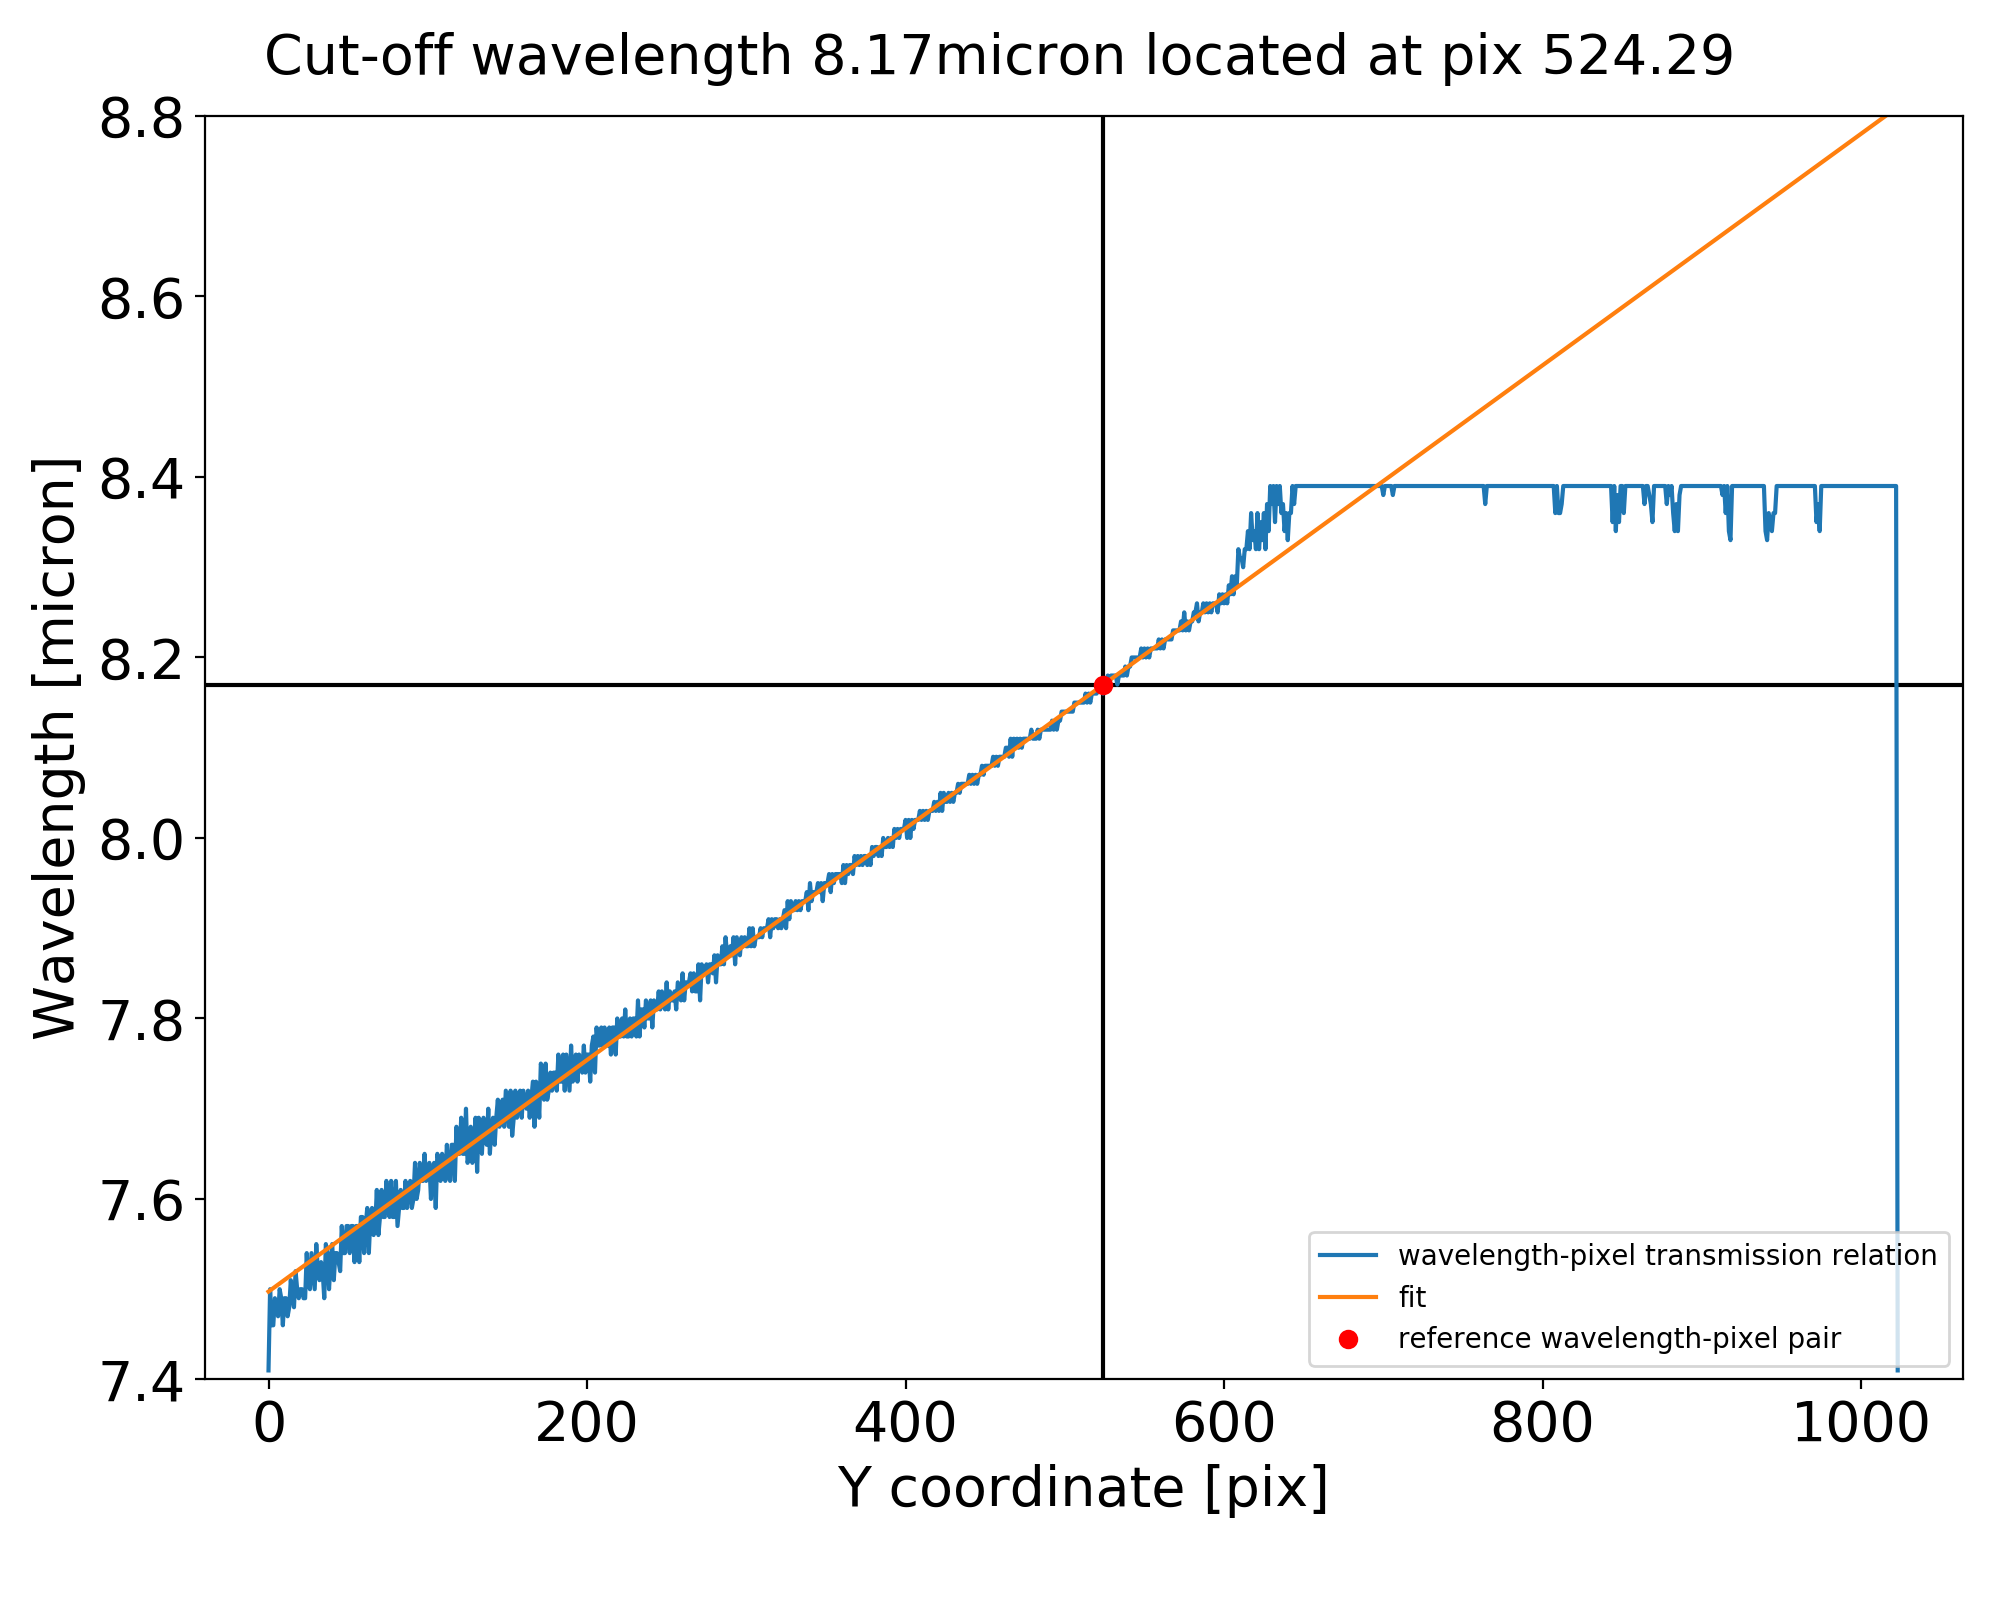

In [23]:
# Method 2: Relate transmission values in wavelength space and in pixel space
matched_wavls = np.full(len(sci_fm_data),np.nan)
sel = (filterWave>7.4) & (filterWave<8.4) # Take range around cut-off (== 8.17 microns)

for i in range(len(sci_fm_data)):
    matched_wavls[i] = filterWave[sel][np.abs((D1B/D1A)[sel]-sci_fm_data[i]).argmin()]

popt = np.polyfit(np.arange(len(sci_fm_data))[400:600],matched_wavls[400:600],1)
cutoffpix = (cutofflamb-popt[1])/popt[0]

plt.figure(figsize=(10,8))
plt.plot(np.arange(1024),matched_wavls,label='wavelength-pixel transmission relation') 
plt.plot(straight_line(np.arange(1024),*popt),label='fit')
plt.plot(cutoffpix,cutofflamb,'ro',label='reference wavelength-pixel pair')
plt.vlines(cutoffpix,7.4,8.8)
plt.hlines(cutofflamb,-40,1064)
plt.xlim(-40,1064)
plt.ylim(7.4,8.8)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Wavelength [micron]',fontsize=20)
plt.suptitle('Cut-off wavelength {}micron located at pix {}'.format(cutofflamb,round(cutoffpix,2) ),fontsize=20)
plt.legend(loc='lower right')
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

In [25]:
print 'YANNIS Reference wavelength: {} micron'.format(round(cutofflamb,3))
print 'YANNIS Reference pixel: {} pix'.format(round(cutoffpix,3))

yan_ref = np.array([cutofflamb,cutoffpix])
# alo_ref = np.array([lam_ref_val, params[0]])
print yan_ref
# print alo_ref

YANNIS Reference wavelength: 8.17 micron
YANNIS Reference pixel: 524.286 pix
[   8.17        524.28629471]


In [26]:
# save output
save_file = open('data/Band'+str(band)+'_Dichroic_refslice'+str(islice)+'_alpha'+str(alpha_pos)+'_refpoint_'+user+'.txt', 'w')
save_file.write('# Band '+str(band)+'   Dichroic   RefSlice '+str(islice)+'\n')
save_file.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(band)+'_Dichroic_refslice'+str(islice)+'_alpha'+str(alpha_pos)+'\n')
save_file.write('\n')
save_file.write('# Reference Wavelength  Reference pixel (pix)\n')

if user == 'yannis':
    save_file.write(str(yan_ref[0])+'  '+str(yan_ref[1]))
elif user == 'alvaro':
    save_file.write(str(alo_ref[0])+'  '+str(alo_ref[1]))
save_file.close()

## IDEA FOR UNCERTAINTIES:

Run mMontecarlo on Alvaro's fit (Can it be done for Yannis's too? 

The idea is to create many (1000?) curves varying the throughput and wavelength  (or pixel) data points within their error bars (half a pixel?), rerun the fit for all of them, and check the variations